In [1]:
# Setup workspace 
import google.datalab.ml as ml
import json
import math
import matplotlib.pyplot as plot
import mltoolbox.regression.dnn as regression
import numpy as np
import pandas as pd
import os
import seaborn as sns
import sklearn.metrics as metrics

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
workspace_path = '/DataVisual/datalab/workspace/taxi'

In [3]:
!mkdir -p {workspace_path}

In [4]:
import google.datalab.bigquery as bq

In our initial query we pulled July 2015 data from the bigquery NYC yelllow taxi. Since the dataset has over 6 million records, we used 100,000 records for testing. 

In [5]:
%%bq query --name taxi_sample
SELECT 
    EXTRACT(TIME FROM pickup_datetime) as tod,
    EXTRACT(DAYOFWEEK FROM pickup_datetime) as dow,
    pickup_datetime, 
    dropoff_datetime,
    rate_code,
    trip_distance, 
    fare_amount,
    extra,
    tip_amount,
    total_amount,
    ride_minutes

FROM 
#`bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016` 
`ucf-automate-nyc.cleaned.JULY_2015`
WHERE trip_distance > 0 AND fare_amount > 0 AND dropoff_datetime > pickup_datetime AND rate_code <> 2
LIMIT 100000

Results for our query were saved to variable

In [6]:
taxi_query = taxi_sample.execute()
taxi_query.result()

tod,dow,pickup_datetime,dropoff_datetime,rate_code,trip_distance,fare_amount,extra,tip_amount,total_amount,ride_minutes
18:39:06,6,2015-07-03 18:39:06,2015-07-03 18:44:31,1,1.1,5.5,0.0,1.57,7.87,5
21:04:52,4,2015-07-29 21:04:52,2015-07-29 21:26:11,1,3.8,16.0,0.5,3.46,20.76,21
12:05:31,6,2015-07-17 12:05:31,2015-07-17 12:38:26,1,11.3,36.0,0.0,55.0,97.34,32
08:23:23,5,2015-07-16 08:23:23,2015-07-16 08:26:26,1,0.52,4.0,0.0,1.44,6.24,3
22:24:49,2,2015-07-20 22:24:49,2015-07-20 22:37:33,1,2.4,11.0,0.5,3.05,15.35,12
04:03:13,2,2015-07-20 04:03:13,2015-07-20 04:46:44,1,11.8,40.5,0.5,8.0,49.8,43
15:35:17,4,2015-07-15 15:35:17,2015-07-15 16:01:42,1,3.7,19.0,0.0,3.95,23.75,26
23:18:21,6,2015-07-31 23:18:21,2015-07-31 23:20:28,1,0.5,3.5,0.5,0.95,5.75,2
18:36:35,6,2015-07-17 18:36:35,2015-07-17 19:04:41,1,2.1,18.0,1.0,3.95,23.75,28
09:52:11,4,2015-07-29 09:52:11,2015-07-29 10:02:18,1,1.0,8.0,0.0,2.6,11.4,10


Our query results were saved to pandas dataframe

In [7]:
taxi_df = taxi_query.result().to_dataframe()
taxi_df.head()

,tod,dow,pickup_datetime,dropoff_datetime,rate_code,trip_distance,fare_amount,extra,tip_amount,total_amount,ride_minutes
0,18:39:06,6,2015-07-03 18:39:06,2015-07-03 18:44:31,1,1.10,5.5,0.0,1.57,7.87,5
1,21:04:52,4,2015-07-29 21:04:52,2015-07-29 21:26:11,1,3.80,16.0,0.5,3.46,20.76,21
2,12:05:31,6,2015-07-17 12:05:31,2015-07-17 12:38:26,1,11.30,36.0,0.0,55.00,97.34,32
3,08:23:23,5,2015-07-16 08:23:23,2015-07-16 08:26:26,1,0.52,4.0,0.0,1.44,6.24,3
4,22:24:49,2,2015-07-20 22:24:49,2015-07-20 22:37:33,1,2.40,11.0,0.5,3.05,15.35,12


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


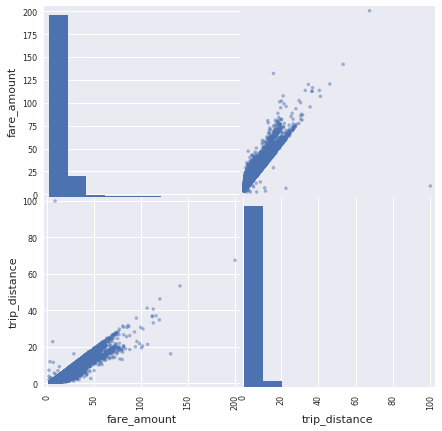

In [8]:
#Visualize 
%matplotlib inline
pd.plotting.scatter_matrix(frame = taxi_df[['fare_amount', 'trip_distance']], figsize=(7,7));

Our first attempt to visualize our results show that the fare_amount is correlated to the trip_distance. We adjusted out dataset by using fares between $3 and $100 and trip distance between 2 and 25 miles then we replotted out plots.

In [9]:
taxi_df_filtered = taxi_df[(taxi_df['fare_amount'] >= 3) & (taxi_df['fare_amount'] <=100)& 
                           (taxi_df['trip_distance'] >=2) & (taxi_df['trip_distance'] <= 25)]

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


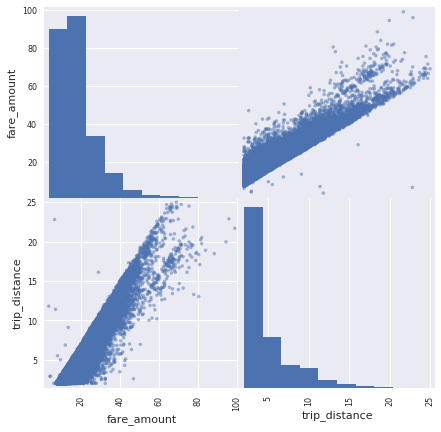

In [10]:
pd.plotting.scatter_matrix(frame = taxi_df_filtered[['fare_amount', 'trip_distance']], figsize=(7,7));

In [11]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [12]:
#Assign data to X and y
#Need to use reshape to create two-d array of values
X=taxi_df_filtered['trip_distance'].values.reshape(-1,1)
y=taxi_df_filtered['fare_amount'].values.reshape(-1,1)
print("Shape: ", X.shape, y.shape)

Shape:  (48220, 1) (48220, 1)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


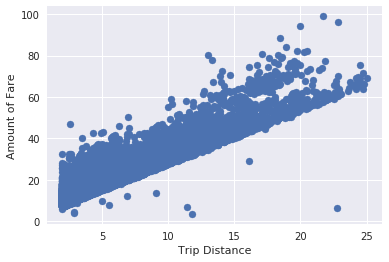

In [13]:
#Plot the data to see if a linear trend exits
plot.scatter(X,y)
plot.xlabel("Trip Distance")
plot.ylabel("Amount of Fare")
plot.savefig("DistFare.png")
plot.show()

In [14]:
#use train_test_split to create training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [15]:
model = LinearRegression()

In [16]:
# Fit the model to the training data and calculate the scores for the training and testing data
model.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
print ('Weight coeff: %.3f' % model.coef_)
print ('y-axis intercept: %.3f' % model.intercept_)       

Weight coeff: 2.711
y-axis intercept: 5.260


In [18]:
#Calculate the MSE and r2 for testing data
#Use our model to make predictions
predicted = model.predict(X_test)

# x_min = X.min()
# x_max = X.max()
# print('Min X Value: %.3f' % x_min)
# print('Max X Value: %.3f' % x_max)

print ('True output: %.3f' % y[0])
print ('Predicted output: %.3f' % predicted[0])
print ('Predicted error: %.3f' % (predicted[0]-y[0]))

True output: 16.000
Predicted output: 17.458
Predicted error: 1.458


In [19]:
#Score the predictions with mse and r2
mse=mean_squared_error(y_test, predicted)
r2=r2_score(y_test, predicted)

print ('Mean Squared Error: %.3f' % mse)
print ('R-squared (r2): %.3f' % r2)

Mean Squared Error: 8.505
R-squared (r2): 0.899


In [21]:
# Call the score method on the model to show the r2 score

testing_score = model.score(X_test, y_test)

print('Testing Score: %.3f' % testing_score)

Testing Score: 0.899


In [22]:
# LASSO model
# use an alpha of .01 when creating model
from sklearn.linear_model import Lasso

In [23]:
lasso=Lasso(alpha=.01).fit(X_train, y_train)
prediction1 = lasso.predict(X_test)

l_mse = mean_squared_error(y_test, prediction1)
l_r2 = lasso.score(X_test, y_test)

print ('Means Squared Error: %.3f' % l_mse)
print ('R-squared (r2): %.3f' % l_r2)

Means Squared Error: 8.505
R-squared (r2): 0.899


In [26]:
# RandomForestRegressor model
#
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train.ravel())
y_pred = regressor.predict(X_test)

In [27]:
rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = regressor.score(X_test, y_test)

print('Mean Square Error: %.3f' % rf_mse)
print('R-squared (r2): %.3f' % rf_r2)

Mean Square Error: 9.335
R-squared (r2): 0.889
